In [1]:
import pandas as pd
import sklearn
import statsmodels
import scipy

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)
print('scipy: ',scipy.__version__)


pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.10.0
scipy:  1.3.0


In [2]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from plotting_functions import *

In [3]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

/home/marco/UD/Starbucks_capstone/capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


In [24]:
out.income=out.income.fillna(65400)
out.age=out.age.fillna(54)
out.gender=out.gender.fillna('M')
out['group118']=out['age']>116
out.loc[out['age']>116,'age']=54



In [25]:

out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])


In [5]:
profile_all.income.mean()

65404.9915682968

In [6]:
profile_all.loc[profile_all.age<110,'age'].mean()

54.39352445193929

In [56]:
from scipy.stats import randint as sp_randint , uniform

from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, auc

from inspect import signature

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import pickle

In [34]:
c_bin_offer=['web','email', 'mobile', 'social','viewed', 'rewarded', 'received', 'comp_not_viewed', 'completed']

c_num_time=['offer_received', 'offer_viewed', 'offer_completed', 'offer_end',]
c_num_offer=['overlaps','offer_reward', 'difficulty', 'duration'  ]
c_num_leak_offer=['Tpay_offer', 'Npay_offer', 'Maxpay_offer', 'Minpay_offer', 'Netpay_offer', 'Avg_pay_offer', 
                  'Avg_pay_outside', 'Avg_D_O','reward', 'duration_viewed','duration_effective', ]
c_num_person=['age', 'income', 'Tpay_out', 'Npay_out', 'user_time' ,'binned_age','binned_income']
c_num_person_ignore=['became_member_on',   'joined_year', 'joined_month','joined_week', 'gender_num',  'duration_hours',]

c_cat_offer=[ 'offer_type' ]

c_bin_person=['group118']
c_cat_person=['gender',]
c_drop_order=['person','offer']

c_num_offers=['p_c_r_ratio','p_c_v_ratio', 'p_cnv_r_ratio','Tpay_offers_tot',
       'Npay_offers_tot', 'Maxpay_offers_tot', 'Minpay_offers_tot',
       'Trewards_tot', 'Nrewards_tot', 'tot_gross_offer_time',
       'tot_net_offers_time', 'tot_not_offers_time', 'Avg_pay_offers',
       'Net_pay_offers', 'Avg_net_pay_offers', 
       'Avg_D_OS','Avg_D_nOS']


In [35]:
out.columns

Index(['person', 'offer', 'offer_received', 'offer_viewed', 'offer_completed',
       'reward', 'offer_end', 'difficulty', 'duration', 'offer_type', 'web',
       'email', 'mobile', 'social', 'offer_reward', 'duration_hours',
       'duration_viewed', 'duration_effective', 'viewed', 'rewarded',
       'received', 'comp_not_viewed', 'completed', 'Tpay_offer', 'Npay_offer',
       'Maxpay_offer', 'Minpay_offer', 'Netpay_offer', 'Avg_pay_offer', 'age',
       'became_member_on', 'gender', 'income', 'joined_year', 'joined_month',
       'joined_week', 'gender_num', 'user_time', 'Tpay_out', 'Npay_out',
       'p_c_r_ratio', 'p_cnv_r_ratio', 'p_c_v_ratio', 'overlaps',
       'Tpay_offers_tot', 'Npay_offers_tot', 'Maxpay_offers_tot',
       'Minpay_offers_tot', 'Trewards_tot', 'Nrewards_tot',
       'tot_gross_offer_time', 'tot_net_offers_time', 'tot_not_offers_time',
       'Avg_pay_offers', 'Net_pay_offers', 'Avg_net_pay_offers',
       'Avg_pay_outside', 'Avg_D_O', 'Avg_D_OS', 'Avg_D_nOS',

In [36]:
c_total=c_bin_offer+c_bin_person+c_num_time+c_num_offer+c_num_leak_offer+c_num_person+c_num_person_ignore + \
    c_cat_offer+c_cat_person+c_num_offers+ c_drop_order

In [37]:
display(set(c_total) ^ set(out.columns))

set()

In [26]:
print("columns with nan:")
fna=list(out.columns[out.isna().any()])
print(fna)

columns with nan:
['offer_viewed', 'offer_completed']


In [173]:
outd=out.copy()
outd=outd.drop(columns=c_num_leak_offer+c_num_offers+c_num_person_ignore+[ 'offer_viewed', 'offer_completed', 'offer_end'])
outd=outd.drop(columns=['viewed', 'rewarded', 'received', 'comp_not_viewed', 'completed','overlaps'])
outd=outd.drop(columns=['person','email'])
outd=outd.drop(columns=['age','income'])

Y=out['viewed']

In [174]:
X_train, X_test, y_train, y_test = train_test_split( outd, Y, test_size=0.3, random_state=0)

In [175]:
outd.head()

,offer,offer_received,difficulty,duration,offer_type,web,mobile,social,offer_reward,gender,user_time,Tpay_out,Npay_out,group118,binned_income,binned_age
0,g,0,5,7,bogo,True,True,False,5,F,443,0.00,0.0,False,90,70
1,g,0,5,7,bogo,True,True,False,5,M,1282,52.08,13.0,False,40,50
2,g,0,5,7,bogo,True,True,False,5,M,747,40.94,14.0,False,30,30
3,g,0,5,7,bogo,True,True,False,5,M,19,0.00,0.0,False,30,40
4,g,0,5,7,bogo,True,True,False,5,F,534,0.00,0.0,False,70,50


In [176]:
numeric_features = ['Tpay_out', 'Npay_out']
categorical_features = ['offer', 'offer_received', 'difficulty', 'duration', 'offer_type',
       'web', 'mobile', 'social', 'offer_reward', 'gender','group118', 'binned_income', 'binned_age']
binary_features=[]    

In [184]:
def fit_col_transformer(X_train,categorical_features,numeric_features):
    ohe= OneHotEncoder(handle_unknown='ignore')
    ssc=StandardScaler()

    ohe.fit(X_train[categorical_features])
    ssc.fit(X_train[numeric_features])
    return(ohe,ssc)
    
def apply_transformer(ohe,ssc,X,categorical_features,numeric_features,binary_features):
    xoh=ohe.transform(X[categorical_features]).todense()
    dfoh=pd.DataFrame(data=xoh,columns=ohe.get_feature_names(input_features=categorical_features))
    
    xn=ssc.transform(X[numeric_features])
    dfxn=pd.DataFrame(data=xn,columns=numeric_features)
    
    if len(binary_features)>0:
        dfxb=X[binary_features].astype(int)
        out=pd.concat( (dfoh,dfxn,dfxb),axis=1 )
    
    out=pd.concat( (dfoh,dfxn),axis=1 )
    
    return(out)
        

In [185]:
ohe,ssc=fit_col_transformer(X_train,categorical_features,numeric_features)

In [186]:
XT_train=apply_transformer(ohe,ssc,X_train,categorical_features,numeric_features,binary_features)
XT_test=apply_transformer(ohe,ssc, X_test,categorical_features,numeric_features,binary_features)


In [187]:
XT_train.head()

,offer_a,offer_b,offer_c,offer_d,offer_e,offer_f,offer_g,offer_h,offer_i,offer_j,...,binned_age_30,binned_age_40,binned_age_50,binned_age_60,binned_age_70,binned_age_80,binned_age_90,binned_age_100,Tpay_out,Npay_out
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.249806,-0.350780
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068193,-0.043980
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.083388,1.183218
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.249806,-0.350780
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.249806,-0.350780


In [188]:
print("columns with nan:")
fna=list(XT_train.columns[XT_train.isna().any()])
print(fna)

columns with nan:
[]


In [189]:
clf=RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")

In [190]:
clf.fit(XT_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=20, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [191]:
clf.score(XT_test, y_test)

0.7500436986540815

In [192]:
outd=out.copy()
outd=outd.drop(columns=c_num_leak_offer+c_num_offers+c_num_person_ignore+[ 'offer_viewed', 'offer_completed', 'offer_end'])
outd=outd.drop(columns=['viewed', 'rewarded', 'received', 'comp_not_viewed', 'completed','overlaps'])
outd=outd.drop(columns=['person','email'])
outd=outd.drop(columns=['age','income'])

Y=out['comp_not_viewed']

In [193]:
X_train, X_test, y_train, y_test = train_test_split( outd, Y, test_size=0.3, random_state=0)

In [199]:
numeric_features = ['Tpay_out', 'Npay_out']
binary_features=[       'web', 'mobile', 'social','group118']

categorical_features = ['offer', 'offer_received', 'gender', 'difficulty', 'duration', 'offer_type',
       'offer_reward', 'gender' , 'binned_income', 'binned_age']
    

In [200]:
ohe,ssc=fit_col_transformer(X_train,categorical_features,numeric_features)
XT_train=apply_transformer(ohe,ssc,X_train,categorical_features,numeric_features,binary_features)
XT_test=apply_transformer(ohe,ssc,X_test,categorical_features,numeric_features,binary_features)

In [201]:
clf=RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")

In [202]:
clf.fit(XT_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=20, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [203]:
print("model score: %.3f" % clf.score(XT_test, y_test))

model score: 0.844


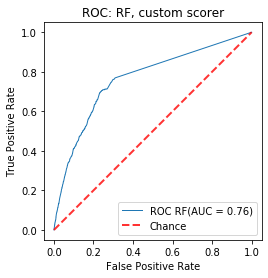

In [204]:
clf.fit(XT_train,y_train)
probas_ = clf.predict_proba(XT_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC RF(AUC = %0.2f)' % (roc_auc));
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: RF, custom scorer')
plt.legend(loc="lower right");
plt.axis('square');

In [205]:
display(confusion_matrix(y_test, clf.predict(XT_test)))
display(confusion_matrix(y_test, 0*y_test))


array([[18525,  2636],
       [  936,   787]])

array([[21161,     0],
       [ 1723,     0]])

In [206]:
y_test.value_counts()

False    21161
True      1723
Name: comp_not_viewed, dtype: int64

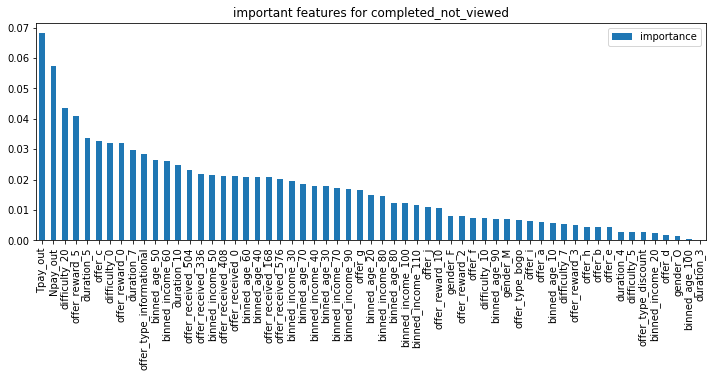

In [207]:
feat=pd.DataFrame.from_dict(dict(zip(XT_train.columns,clf.feature_importances_) ), orient='index',columns=['importance'])
feat=feat.sort_values(by=['importance'],ascending=False)

feat.plot(kind='bar',figsize=(12,4));
plt.title('important features for completed_not_viewed');
